# Avocado Ripeness Classification

Dataset taken from <a href="https://www.kaggle.com/datasets/amldvvs/avocado-ripeness-classification-dataset">Kaggle</a>

<hr>

**Type:** categorical, multinomial classification

**Goal:** to predict its ripeness

**Target variables:** hard, pre-conditioned, breaking, firm-ripe, ripe

**Independent features:** firmness, hue, saturation, brightness, brightness, color_category, sound_db, weight_g, size_cm3

In [2]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import missingno as msno

# models to use
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


### Exloratory Data Analysis

In [3]:
# read dataset

df = pd.read_csv('../datasets/avocado_ripeness_dataset.csv')

df

,firmness,hue,saturation,brightness,color_category,sound_db,weight_g,size_cm3,ripeness
0,14.5,19,40,26,black,34,175,261,ripe
1,71.7,53,69,75,green,69,206,185,pre-conditioned
2,88.5,60,94,46,dark green,79,220,143,hard
3,93.8,105,87,41,dark green,75,299,140,hard
4,42.5,303,58,32,purple,63,200,227,breaking
...,...,...,...,...,...,...,...,...,...
245,94.1,83,80,58,dark green,72,254,134,hard
246,21.6,17,36,19,black,47,182,240,firm-ripe
247,14.0,4,40,17,black,37,188,274,ripe
248,61.5,63,87,75,green,65,261,162,pre-conditioned


In [4]:
# describe

df.describe()

,firmness,hue,saturation,brightness,sound_db,weight_g,size_cm3
count,250.000000,250.00000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,50.618400,125.94400,64.356000,45.07200,58.016000,220.188000,208.644000
std,27.277678,117.13767,17.377144,19.11629,13.838126,34.405225,55.940564
min,10.300000,1.00000,30.000000,10.00000,30.000000,152.000000,100.000000
25%,25.750000,25.25000,51.250000,31.00000,47.250000,193.250000,155.250000
50%,48.950000,77.00000,65.000000,46.00000,60.000000,220.000000,218.000000
75%,74.050000,278.75000,76.750000,58.00000,68.000000,245.000000,260.500000
max,98.800000,329.00000,99.000000,78.00000,79.000000,299.000000,299.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   firmness        250 non-null    float64
 1   hue             250 non-null    int64  
 2   saturation      250 non-null    int64  
 3   brightness      250 non-null    int64  
 4   color_category  250 non-null    object 
 5   sound_db        250 non-null    int64  
 6   weight_g        250 non-null    int64  
 7   size_cm3        250 non-null    int64  
 8   ripeness        250 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 17.7+ KB


In [6]:
df.isna().sum()

firmness          0
hue               0
saturation        0
brightness        0
color_category    0
sound_db          0
weight_g          0
size_cm3          0
ripeness          0
dtype: int64

In [7]:
df['ripeness'].value_counts()

ripeness
ripe               50
pre-conditioned    50
hard               50
breaking           50
firm-ripe          50
Name: count, dtype: int64

In [8]:
df['color_category'].value_counts()

color_category
black         75
purple        75
green         50
dark green    50
Name: count, dtype: int64

### Preprocessing

In [9]:
x = df.drop(['ripeness'], axis=1)
x.head(5)

,firmness,hue,saturation,brightness,color_category,sound_db,weight_g,size_cm3
0,14.5,19,40,26,black,34,175,261
1,71.7,53,69,75,green,69,206,185
2,88.5,60,94,46,dark green,79,220,143
3,93.8,105,87,41,dark green,75,299,140
4,42.5,303,58,32,purple,63,200,227


In [10]:
y = df['ripeness']
y.head(5)

0               ripe
1    pre-conditioned
2               hard
3               hard
4           breaking
Name: ripeness, dtype: object

In [11]:
# split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# categorical and numerical
categorical = ['color_category']
numerical = ['firmness', 'hue', 'saturation', 'brightness', 'sound_db', 'weight_g', 'size_cm3']

# target encoding
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [14]:
# tree-based models

tree_preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(), categorical),
    ('num', 'passthrough', numerical)
])

# decision tree
dt_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# random forest
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', RandomForestClassifier())
])

# gradient boosting
gb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', GradientBoostingClassifier())
])


In [15]:
# linear-based models

linear_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'),categorical),
    ('num', StandardScaler(), numerical)
])

knn_pipeline = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('classifier', KNeighborsClassifier()),
])

svm_pipeline = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('classifier', SVC(probability=True)),
])

nb_pipeline = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('classifier', GaussianNB())
])

In [16]:
# cross val score tree-based model
print('Tree-based models:')

dt_scores = cross_val_score(dt_pipeline, x, y_encoded, cv=skf, scoring='accuracy')
rf_scores = cross_val_score(rf_pipeline, x, y_encoded, cv=skf, scoring='accuracy')
gb_scores = cross_val_score(gb_pipeline, x, y_encoded, cv=skf, scoring='accuracy')

print(f"Decision Tree Cross-val accuracy: {np.mean(dt_scores)}")
print(f"Random Forest Cross-val accuracy: {np.mean(rf_scores)}")
print(f"Gradient Boosting Cross-val accuracy: {np.mean(gb_scores)}")

# cross val score linear-based model
print("\nLinear-based models:")

knn_scores = cross_val_score(knn_pipeline, x, y_encoded, cv=skf, scoring='accuracy')
svm_scores = cross_val_score(svm_pipeline, x, y_encoded, cv=skf, scoring='accuracy')
nb_scores = cross_val_score(nb_pipeline, x, y_encoded, cv=skf, scoring='accuracy')


print(f"K-Nearest Neighbors Cross-val accuracy: {np.mean(knn_scores)}")
print(f"Support Vector Machine Cross-val accuracy: {np.mean(svm_scores)}")
print(f"Naive Bayes Cross-val accuracy: {np.mean(nb_scores)}")


Tree-based models:
Decision Tree Cross-val accuracy: 1.0
Random Forest Cross-val accuracy: 1.0
Gradient Boosting Cross-val accuracy: 1.0

Linear-based models:
K-Nearest Neighbors Cross-val accuracy: 0.9879999999999999
Support Vector Machine Cross-val accuracy: 0.9960000000000001
Naive Bayes Cross-val accuracy: 0.9120000000000001


In [17]:
# final evaluation of hold-out set for tree-based models

# storing accuracies

holdout_accuracies = {
    "tree-based": [],
    "linear-based":[],
}

def final_eval_holdout(pipeline, X_test, Y_test, model_name, category_key, storage_dict):
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(Y_test, y_pred)
    storage_dict[category_key].append((model_name, acc))
    
    # printing eval results
    print("Accuracy score on test set:", acc)
    print("\nClassification report:\n", classification_report(Y_test, y_pred, target_names=le_target.classes_))
    print("\nConfusion matrix:\n", confusion_matrix(Y_test, y_pred))


In [18]:
# tree based
dt_pipeline.fit(x_train, y_train)
rf_pipeline.fit(x_train, y_train)
gb_pipeline.fit(x_train, y_train)

print("\n=== Decision Tree ===")
final_eval_holdout(dt_pipeline, x_test, y_test, "Decision Tree", "tree-based", holdout_accuracies)

print("\n=== Random Forest ===")
final_eval_holdout(rf_pipeline, x_test, y_test, "Random Forest", "tree-based", holdout_accuracies)

print("\n=== Gradient Boosting ===")
final_eval_holdout(gb_pipeline, x_test, y_test, "Gradient Boosting", "tree-based", holdout_accuracies)


=== Decision Tree ===
Accuracy score on test set: 1.0

Classification report:
                  precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        13
      firm-ripe       1.00      1.00      1.00         9
           hard       1.00      1.00      1.00         8
pre-conditioned       1.00      1.00      1.00         7
           ripe       1.00      1.00      1.00        13

       accuracy                           1.00        50
      macro avg       1.00      1.00      1.00        50
   weighted avg       1.00      1.00      1.00        50


Confusion matrix:
 [[13  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0 13]]

=== Random Forest ===
Accuracy score on test set: 1.0

Classification report:
                  precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        13
      firm-ripe       1.00      1.00      1.00         9
           hard       1.00      1.00     

In [19]:
# linear-based 
knn_pipeline.fit(x_train, y_train)
svm_pipeline.fit(x_train, y_train)
nb_pipeline.fit(x_train, y_train)

print("\n=== KNN ===")
final_eval_holdout(knn_pipeline, x_test, y_test, "KNN","linear-based", holdout_accuracies)

print("\n=== SVM ===")
final_eval_holdout(svm_pipeline, x_test, y_test, "SVM","linear-based", holdout_accuracies)

print("\n=== Naive Bayes ===")
final_eval_holdout(nb_pipeline, x_test, y_test, "Naive Bayes","linear-based", holdout_accuracies)


=== KNN ===
Accuracy score on test set: 1.0

Classification report:
                  precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        13
      firm-ripe       1.00      1.00      1.00         9
           hard       1.00      1.00      1.00         8
pre-conditioned       1.00      1.00      1.00         7
           ripe       1.00      1.00      1.00        13

       accuracy                           1.00        50
      macro avg       1.00      1.00      1.00        50
   weighted avg       1.00      1.00      1.00        50


Confusion matrix:
 [[13  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  7  0]
 [ 0  0  0  0 13]]

=== SVM ===
Accuracy score on test set: 1.0

Classification report:
                  precision    recall  f1-score   support

       breaking       1.00      1.00      1.00        13
      firm-ripe       1.00      1.00      1.00         9
           hard       1.00      1.00      1.00         8
pre-

In [20]:
print("\n--- Hold-out Set Accuracies ---")

print("\nTree-based Models:")
for model, acc in holdout_accuracies["tree-based"]:
    print(f"{model}: {acc:.4f}")

print("\nLinear-based Models:")
for model, acc in holdout_accuracies["linear-based"]:
    print(f"{model}: {acc:.4f}")


--- Hold-out Set Accuracies ---

Tree-based Models:
Decision Tree: 1.0000
Random Forest: 1.0000
Gradient Boosting: 1.0000

Linear-based Models:
KNN: 1.0000
SVM: 1.0000
Naive Bayes: 0.9400


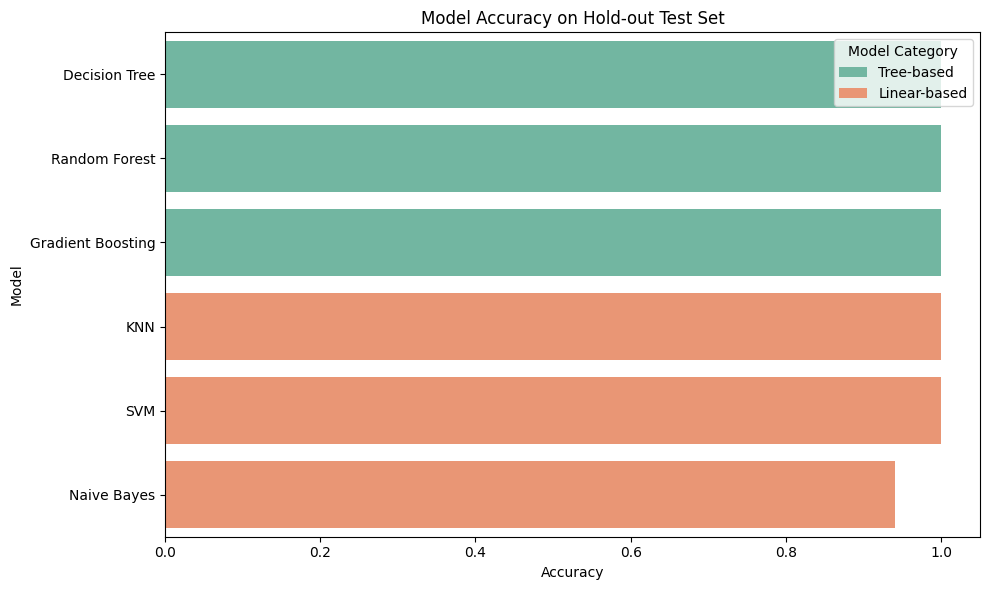

In [21]:
all_results = holdout_accuracies["tree-based"] + holdout_accuracies["linear-based"]
df_results = pd.DataFrame(all_results, columns=["Model", "Accuracy"])

df_results["Category"] = ["Tree-based"] * len(holdout_accuracies["tree-based"]) + \
                         ["Linear-based"] * len(holdout_accuracies["linear-based"])

df_results = df_results.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Accuracy", y="Model", hue="Category", palette="Set2")
plt.title("Model Accuracy on Hold-out Test Set")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.0, 1.05)
plt.legend(title="Model Category")
plt.tight_layout()
plt.show()

### Observations and insights
- All models performed strongly, exhibiting a perfect 1.0 score on accuracy, except Naive Bayes model. This is likely due to how GaussianNB assumed strong independence among features and poor modeling of feature distributions.